# House Price Predictions
This kernel aim to predict the price of houses using machine learning techniques. the data is obtain from kaggle competition "House Prices: Advanced Regression Techniques" which consist of 81 variable describe the details of each house in the datasets.
I used multiple regression to predict the prices and provide details on how to detect the model assumption, overfitting and underfiting and predictions.
the main challange here is the sample size relative to number of features so split the variables according to their type and only make nominal featurs into dummy variables.


In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# reading datasets
df1=pd.read_csv("C:\\Users\\my\\Desktop\\train.csv")
df2=pd.read_csv("C:\\Users\\my\\Desktop\\test.csv")
df3=pd.read_csv("C:\\Users\\my\\Desktop\\sample_submission.csv")

test_data=pd.merge(df2,df3,on="Id")
test_data["sample"]="test"
df1["sample"]="train"
train=pd.concat([df1,test_data],axis=0)


# Data Cleaning 


In [3]:
#1- Changing feature types
train["MSSubClass"]=train["MSSubClass"].astype("object")

#2- Dealing with missing data
#2-a Checking number of missing values 
missing=(train.isnull().sum()/len(train)).to_frame().sort_values(by=0,ascending=False).head(20)

#2-b Delete the columns with high missing percentage(over 80%)
train.drop(["PoolQC","MiscFeature","Alley","Fence"],axis=1,inplace=True)

#2-c Replace missing values
train["FireplaceQu"].fillna("NFP",inplace=True) # NFP= NO fireplace
train["LotFrontage"].fillna(0,inplace=True)

train["GarageType"].fillna("NG",inplace=True) # NG = NO Garage
train["GarageQual"].fillna("NG",inplace=True)
train["GarageCond"].fillna("NG",inplace=True)
train["GarageFinish"].fillna("NG",inplace=True)


train["BsmtExposure"].fillna("NB",inplace=True) # NB = NO Basement
train["BsmtCond"].fillna("NB",inplace=True)
train["BsmtQual"].fillna("NB",inplace=True)
train["BsmtFinType2"].fillna(0,inplace=True)
train["BsmtFinType1"].fillna(0,inplace=True)


train["MasVnrArea"].fillna(0,inplace=True)
train["MasVnrType"].fillna("None",inplace=True)

train["Functional"].fillna(train["Functional"].value_counts().index[0],inplace=True)
train["KitchenQual"].fillna(train["KitchenQual"].value_counts().index[0],inplace=True)

In [4]:
# Feature Enginnering
#1- split the data into continous and categorical data 
cont=train[train.columns[train.dtypes != "object"]]
cont.drop(["Id"],axis=1,inplace=True)
cont.fillna(0,inplace=True)

cat=train[train.columns[train.dtypes == "object"]]

#2- split the categorical data into rating and non_rating
rating=["GarageCond","GarageQual","GarageFinish","FireplaceQu","Functional","KitchenQual","HeatingQC",
        "BsmtFinType2","BsmtFinType1","BsmtExposure","BsmtCond","BsmtQual","ExterCond","ExterQual","HouseStyle","BldgType",
       "LandSlope","Utilities","LotShape"]
non_rating=cat.columns.difference(rating)

cat_rating=cat[rating]
cat_non_rating=cat[non_rating]

In [5]:
# Data Preprocessing
#1- convert all non rating features into dummy variables
dummy=pd.get_dummies(cat_non_rating).reset_index(drop=True)

#2-convert all rating features into contionus variables
cat_rating[["GarageCond","GarageQual","KitchenQual","HeatingQC","BsmtCond","BsmtQual","ExterCond","ExterQual"]]=cat_rating[["GarageCond","GarageQual","KitchenQual","HeatingQC","BsmtCond","BsmtQual","ExterCond","ExterQual"]].replace({"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1,"NG":0,"NB":0})
cat_rating["GarageFinish"]=cat_rating["GarageFinish"].replace({"Fin":3,"RFn":2,"Unf":1,"NG":0})
cat_rating["FireplaceQu"]=cat_rating["FireplaceQu"].replace({"Ex":5,"Gd":4,"TA":3,"Fa":2,"Po":1,"NFP":0})
cat_rating["Functional"]=cat_rating["Functional"].replace({"Sal":0,"Sev":1,"Maj2":2,"Maj1":3,"Mod":4,"Min2":5,"Min1":6,"Typ":7})
cat_rating["BsmtFinType2"]=cat_rating["BsmtFinType2"].replace({"NB":0,"Unf":1,"LwQ":2,"Rec":3,"BLQ":4,"ALQ":5,"GLQ":6})
cat_rating["BsmtFinType1"]=cat_rating["BsmtFinType1"].replace({"NB":0,"Unf":1,"LwQ":2,"Rec":3,"BLQ":4,"ALQ":5,"GLQ":6})
cat_rating["HouseStyle"]=cat_rating["HouseStyle"].replace({"1Story":0,"1.5Unf":1,"1.5Fin":2,"2Story":3,"2.5Unf":4,"2.5Fin":5,"SFoyer":6,"SLvl":7})
cat_rating["BldgType"]=cat_rating["BldgType"].replace({"1Fam":1,"2fmCon":2,"Duplex":3,"Twnhs":4,"TwnhsI":5,"TwnhsE":4})
cat_rating["LandSlope"]=cat_rating["LandSlope"].replace({"Gtl":3,"Mod":2,"Sev":1})
cat_rating["Utilities"]=cat_rating["Utilities"].replace({"AllPub":4,"NoSewr":3,"NoSeWa":2,"ELO":1})
cat_rating["LotShape"]=cat_rating["LotShape"].replace({"Reg":4,"IR1":3,"IR2":2,"IR3":1})
cat_rating["BsmtExposure"]=cat_rating["BsmtExposure"].replace({"NB":0,"No":1,"Mn":2,"Av":3,"Gd":4})



# Model Building

In [6]:
#prepare the data
dummy.reset_index(drop=True,inplace=True)
cat_rating.reset_index(drop=True,inplace=True)
cont.reset_index(drop=True,inplace=True)

model_data= pd.concat([dummy,cat_rating.drop(["Utilities"],axis=1),cont.drop(["GarageYrBlt"],axis=1)],axis=1)
train=model_data[model_data["sample_train"]==1].drop(["sample_train","sample_test"],axis=1)
test=model_data[model_data["sample_test"]==1].drop(["sample_train","sample_test"],axis=1)

#Model Building
X=sm.add_constant(train.drop(["SalePrice"],axis=1))
Y=np.log(train.SalePrice+1)

lm = sm.OLS(Y, X).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     100.0
Date:                Fri, 01 May 2020   Prob (F-statistic):               0.00
Time:                        23:38:36   Log-Likelihood:                 1312.2
No. Observations:                1460   AIC:                            -2232.
Df Residuals:                    1264   BIC:                            -1196.
Df Model:                         195                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.3698      0.994      2.385      0.017       0.420       4.319
CentralAir_N              1.1559      0.497      2.326      0.020       0.181       2.131
CentralAir_Y              1.2140      0.497      2.443      0.015       0.239       2.189
Condition1_Artery         0.2243      0.113      1.993      0.046       0.003       0.445
Condition1_Feedr          0.2570      0.111      2.309      0.021       0.039       0.475
Condition1_Norm           0.3054      0.111      2.757      0.006       0.088       0.523
Condition1_PosA           0.2838      0.118      2.409      0.016       0.053       0.515
Condition1_PosN           0.3115      0.115      2.701      0.007       0.085       0.538
Condition1_RRAe           0.1848      0.115      1.612      0.107      -0.040       0.410
Condition1_RRAn           0.2727      0.112      2.428      0.015       0.052       0.493
Condition1_RRNe           0.2344      0.132      1.782      0.075      -0.024       0.493
Condition1_RRNn           0.2959      0.121      2.445      0.015       0.058       0.533
Condition2_Artery         0.3960      0.152      2.604      0.009       0.098       0.694
Condition2_Feedr          0.4580      0.141      3.250      0.001       0.182       0.734
Condition2_Norm           0.4373      0.130      3.358      0.001       0.182       0.693
Condition2_PosA           0.6599      0.166      3.987      0.000       0.335       0.985
Condition2_PosN          -0.4248      0.150     -2.836      0.005      -0.719      -0.131
Condition2_RRAe           0.0327      0.210      0.156      0.876      -0.380       0.445
Condition2_RRAn           0.3825      0.161      2.377      0.018       0.067       0.698
Condition2_RRNn           0.4282      0.148      2.901      0.004       0.139       0.718
Electrical_FuseA         -0.0522      0.112     -0.466      0.642      -0.272       0.168
Electrical_FuseF         -0.0636      0.114     -0.559      0.576      -0.287       0.160
Electrical_FuseP         -0.0782      0.134     -0.582      0.561      -0.342       0.185
Electrical_Mix           -0.0662      0.164     -0.404      0.686      -0.388       0.255
Electrical_SBrkr         -0.0721      0.111     -0.648      0.517      -0.290       0.146
Exterior1st_AsbShng       0.1981      0.083      2.382      0.017       0.035       0.361
Exterior1st_AsphShn       0.1459      0.152      0.958      0.338      -0.153       0.445
Exterior1st_BrkComm      -0.1107      0.127     -0.869      0.385      -0.360       0.139
Exterior1st_BrkFace       0.2566      0.073      3.527      0.000       0.114       0.399
Exterior1st_CBlock        0.1282      0.084      1.523      0.128      -0.037       0.293
Exterior1st_CemntBd       0.1245      0.092      1.361      0.174      -0.055       0.304
Exterior1st_HdBoard    

# Checking for model Assumption


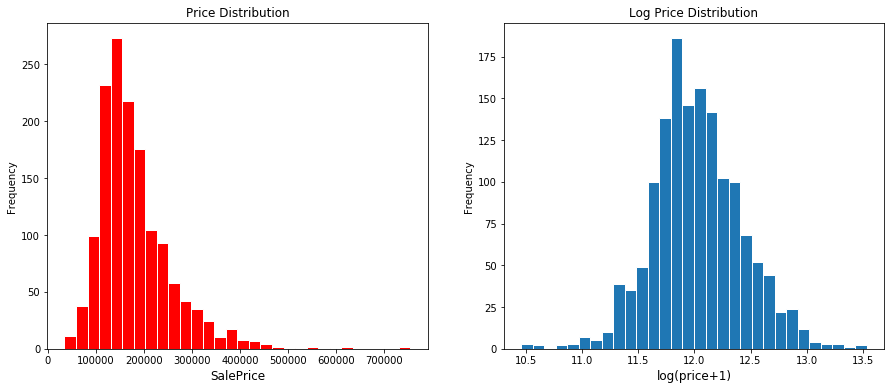

In [7]:
#1- Normality 

#Plot Price Distribution
plt.subplot(1, 2, 1)
(train.SalePrice).plot.hist(bins=30,figsize=(15, 6), edgecolor = 'white',color="red")
plt.xlabel('SalePrice', fontsize=12)
plt.title('Price Distribution', fontsize=12)


#Plot Log Price Distribution
plt.subplot(1, 2, 2)
(np.log(train.SalePrice+1)).plot.hist( bins=30,figsize=(15,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Log Price Distribution', fontsize=12)

plt.show()

You can see here that the original sale price is skewed distribution (red one) and violate the regression assumption of normality. Transformation fixed this on the left(blue one)

In [8]:
#2-  Detecting Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = pd.concat([dummy,cat_rating.drop(["Utilities"],axis=1),cont.drop(["SalePrice","GarageYrBlt"],axis=1)],axis=1).assign(const=1)
vif=pd.Series([variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])],index=X_vif.columns).to_frame()

#x=X[vif[vif[0]<5].T.columns]
#lm2 = sm.OLS(Y, x).fit()
#lm2.summary()

Multicollinearity has no impact if our purpose is to make predictions but if we interest in individual feature impact on target variable, thats different story.

In [9]:
#3- Detecting Heteroskedestacity

# fitted values (need a constant term for intercept)
model_fitted_y = lm.fittedvalues

# model residuals
model_residuals = lm.resid

# normalized residuals
model_norm_residuals = lm.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = lm.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
model_cooks = lm.get_influence().cooks_distance[0]



Text(0, 0.5, 'Residuals')

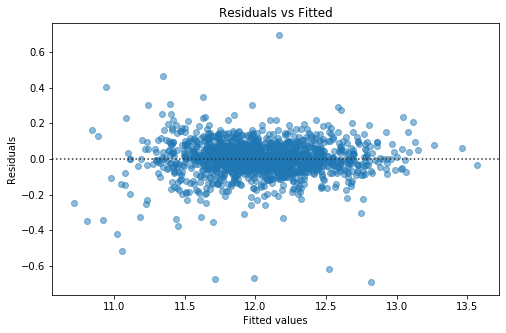

In [10]:
train["logsales"]=np.log(train.SalePrice+1)
# Create residual plot of y vs Residuals
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(5)
plot_lm_1.set_figwidth(8)

model_fitted_y = lm.fittedvalues

plot_lm_1.axes[0] = sns.residplot(model_fitted_y, 'logsales', data=train, 
                          scatter_kws={'alpha': 0.5})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

This residual plot indicate homogenity for residual with zero mean which satisfy the model assumptions

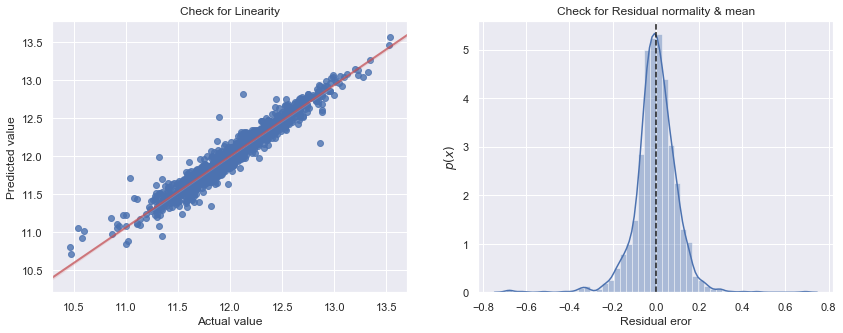

In [11]:
#4 Detecting Linearity, Normal Distribution of Residuals, & Zero Mean
import seaborn as sns; sns.set()

# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
#sns.scatterplot(y_test,y_pred_ols,ax=ax,color=['r','g'])
# use the function regplot to make a scatterplot
sns.regplot(x=train.logsales, y=model_fitted_y, line_kws={"color":"r","alpha":0.7,"lw":2})
plt.title('Check for Linearity')
plt.xlabel('Actual value')
plt.ylabel('Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((train.logsales - model_fitted_y),ax=ax,color='b')
plt.axvline((train.logsales - model_fitted_y).mean(),color='k',linestyle='--')
plt.title('Check for Residual normality & mean')
plt.xlabel('Residual eror')
plt.ylabel('$p(x)$');

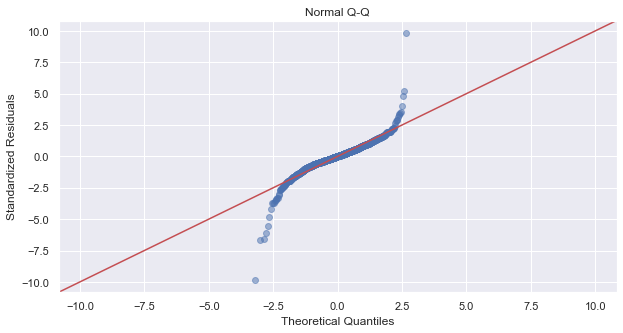

In [12]:
#Detecting Normal Distribution of Residuals - QQ Plot
from statsmodels.graphics.gofplots import ProbPlot

QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

plot_lm_2.set_figheight(5)
plot_lm_2.set_figwidth(10)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

# Overfitting and Under Fitting

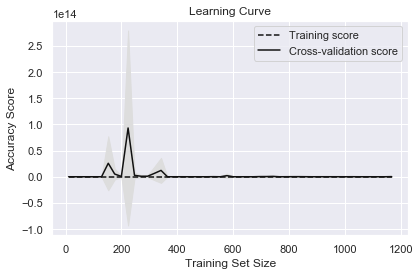

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(LinearRegression(), 
                                                        X, 
                                                        train["logsales"],
                                                        # Number of folds in cross-validation
                                                        cv=5,
                                                        # Evaluation metric
                                                        scoring='neg_mean_squared_error',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50),
                                                         shuffle=True)

# Create means and standard deviations of training set scores
train_mean = - np.mean(train_scores, axis=1)
train_std = - np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean =- np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

The learning curves indicate a good fit

# Predictions

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

lr = LinearRegression()
lr.fit(X, Y)
predictions = lr.predict(sm.add_constant(test.drop(["SalePrice"],axis=1)))

rmse = format(np.sqrt(mean_squared_error(np.log(test.SalePrice+1), predictions)),'.3f')
mae = format(mean_absolute_error(np.log(test.SalePrice+1), predictions),'.3f')

# Print out result
print("Root Mean Squared Error: ", format(np.sqrt(mean_squared_error(np.log(test.SalePrice+1), predictions)),'.3f'))
print("Mean Absolute Error: ", format(mean_absolute_error(np.log(test.SalePrice+1), predictions),'.3f'))

Root Mean Squared Error:  294.638
Mean Absolute Error:  20.981


# References
*DSDJ Course<br/>
*https://chrisalbon.com/machine_learning/model_evaluation/plot_the_learning_curve/
